# Simulation

In [1]:
# %load ./../../../games/connect-four/connect-four.py
import numpy as np

class ConnectFourSimulator:
	"""Creates a connect-4 board and simulates it, returning states and rewards for any taken action.

	The creates board is a 6 x 7 (rows x cols) array. Empty fields are denoted by 0.
	Tokens placed by player one are denoted by '1' and player two uses '-1'.
	Every field is part of the state and has it's own index, simply counting from 0 to 41 along the rows
	like so [
		[0, 1, 2, 3, 4, 5, 6],
		[7, 8, 9, 10, 11, 12, 13],
		...
		[35, 36, 37, 38, 39, 40, 41]
	]
	"""
	def __init__(self):
		self.width = 7
		self.height = 6
		self.board = np.zeros(shape=(self.height, self.width))
		self.PLAYER1 = 1
		self.PLAYER2 = -1
		self.DRAW = 0
		self.current_player = self.PLAYER1
		self.__game_over = False

	def take_action(self, action):
		"""Executes the action and returns the next state and the received reward."""
		active_player = self.current_player
		inactive_player = self.__negated_player(active_player)
		if not self.__action_is_valid(action):
			return self.__game_over, np.copy(self.board), active_player, -2, inactive_player, 0

		self.__play_move(action)

		self.__game_over = self.__game_is_over(action)
		if self.__game_over:
			winner = self.__winner(action)
			if winner == self.DRAW:
				return self.__game_over, np.copy(self.board), active_player, 0, inactive_player, 0
			elif winner == self.PLAYER1:
				return self.__game_over, np.copy(self.board), active_player, 1000, inactive_player, -100
			else:
				return self.__game_over, np.copy(self.board), active_player, -100, inactive_player, 1000

		return self.__game_over, np.copy(self.board), active_player, 0, inactive_player, 0

	def print_board(self):
		#print(self.board)
		board = self.board
		board = np.where(board == 1, "X", board)
		board = np.where(board == "-1.0", "O", board)
		print(np.where(board == "0.0", "-", board))

	def __play_move(self, action):
		"""Takes an action and executes it."""
		x, y = self.__coordinates_from_action(action)
		self.board[y][x] = self.current_player
		self.current_player = self.__negated_player(self.current_player)

	def __action_is_valid(self, action):
		"""Checks if the intended action is a valid one or if it breaks the rules of the game."""
		if 41 > action < 0:
			return False
		x, y = self.__coordinates_from_action(action)
		if x >= self.width or y >= self.height:
			return False

		height_x = self.__column_height(x)

		if y != height_x:
			return False
		return True

	def __column_height(self, x):
		"""Returns the height of a column which is equal to the amount of tokens placed."""
		column = self.board[:, x]
		return np.count_nonzero(column)

	def __game_is_over(self, last_action):
		"""Returns True if the game is over and False otherwise."""
		if np.count_nonzero(self.board) >= 42:
			return True

		lines = self.__extract_lines(last_action)

		for line in lines:
			if self.__winner_in_line(line) != 0:
				return True

		return False

	def __extract_lines(self, last_action):
		"""Extracts the horizontal, vertical and the diagonal lines going through the last action"""
		x, y = self.__coordinates_from_action(last_action)

		row = self.board[y]
		column = self.board[:, x]
		top_down_diagonal = self.board.diagonal(x - y)

		mirrored_x = self.width - 1 - x
		bot_up_diagonal = np.fliplr(self.board).diagonal(mirrored_x - y)

		return row, column, top_down_diagonal, bot_up_diagonal

	def __winner(self, last_action):
		"""Returns the winner's number or 0 if the game resulted in a draw (Requires the game to have ended)."""
		lines = self.__extract_lines(last_action)

		for line in lines:
			winner = self.__winner_in_line(line)
			if winner != 0:
				return winner

		return 0

	def __winner_in_line(self, line):
		"""Checks if a line contains a winner and returns his number if yes and 0 otherwise."""
		token_sum = 0
		for token in line:
			token_sum += token
			if token_sum == 4 * self.PLAYER1:
				return self.PLAYER1
			if token_sum == 4 * self.PLAYER2:
				return self.PLAYER2
			if token_sum < 0 < token or token_sum > 0 > token:
				token_sum = 0
		return 0

	def __coordinates_from_action(self, action):
		"""Translates an action into (x, y) / (column, row) coordinates."""
		x = action % self.width
		y = action // self.width
		return x, y

	def __negated_player(self, player):
		"""Returns the player not passed to the function (Player1 if Player2 is passed and the other way around)."""
		return self.PLAYER2 if self.current_player == self.PLAYER1 else self.PLAYER1


In [2]:
game = ConnectFourSimulator()

val = input()
while val != "q":
    game_over, board, _, _, _, _ = game.take_action(int(val))
    print(game_over)
    print(board)
    print("------------------------------------")
    val = input()

print(game.take_action(3))
print(game.take_action(4))
print(game.take_action(10))
print(game.take_action(5))
print(game.take_action(17))
print(game.take_action(6))
print(game.take_action(24))

# Agent

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(42, 64)
        #self.fc1.weight.data.fill_(0.0)
        #self.fc1.bias.data.fill_(0.0)
        self.fc2 = nn.Linear(64, 64)
        #self.fc2.weight.data.fill_(0.0)
        #self.fc2.bias.data.fill_(0.0)
        self.fc3 = nn.Linear(64, 42)
        #self.fc3.weight.data.fill_(0.0)
        #self.fc3.bias.data.fill_(0.0)
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
import random

import torch
import torch.optim as optim

class DeepQPytorchAgent:
    def __init__(self, learning_rate=0.0001, discount=0.95, exploration_rate=1.0, iterations=10_000, trained_model=None):
        self.q_table = np.zeros(shape=(42, 42))
        self.learning_rate = learning_rate
        self.discount = discount
        self.exploration_rate = exploration_rate
        self.exploration_delta = exploration_rate / iterations
        
        self.input_count = 42
        self.output_count = 42
        
        self.define_model(trained_model)
    
    def define_model(self, trained_model):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if trained_model:
            self.model = trained_model.to(self.device)
        else:
            self.model = Model().to(self.device)
        
        #self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    def get_Q(self, state):
        x = torch.tensor(state.flatten(), device=self.device).float()
        return self.model(x)
    
    def get_Q_batch(self, states):
        #x = torch.tensor(state.flatten(), device=self.device).float()
        return self.model(states)
        
    def next_action(self, state):
        if random.random() < self.exploration_rate:
            return self.random_action()
        else:
            return self.greedy_action(state)
        
    def random_action(self):
        return random.randrange(0, 42) # Maybe change the probability distribution?
    
    def greedy_action(self, state):
        #print("Greedy1:", torch.max(self.get_Q(state), 0)[0])
        #print("Greedy2:", torch.max(self.get_Q(state), 0)[1])
        return torch.max(self.get_Q(state), 0)[1]
    
    def update(self, old_state, new_state, action, reward):
        self.train(old_state, new_state, action, reward)
        # TODO: Maybe change algorithm?
        if self.exploration_rate > 0:
            self.exploration_rate = max(0.2, self.exploration_rate - self.exploration_delta)
        
    def update_batch(self, old_states, new_states, actions, rewards):
        self.train_batch(old_states, new_states, actions, rewards)
        
        if self.exploration_rate > 0:
            self.exploration_rate = max(0.05, self.exploration_rate - self.exploration_delta)

    def train(self, old_state, new_state, action, reward):
        #print("OldState:", old_state)
        #print("NewState:", new_state)
        #print("Reward:", reward)
        old_state_values = self.get_Q(old_state)
        new_state_values = self.get_Q(new_state).detach()
        #print("OldQ:", old_state_values)
        #print("NewQ:", new_state_values)
        
        new_reward = reward + self.discount * torch.max(new_state_values)
        #print("NewReward:", new_reward)
        updated_state_values = old_state_values.clone().detach() # Check if detach could cause problems
        #print("BeforeUpdate:", updated_state_values)
        #print("Updating action:", action)
        updated_state_values[action] = new_reward
        #print("OldAfterUpdate:", old_state_values)
        #print("UpdAfterUpdate:", updated_state_values)
        
        # in your training loop:
        self.optimizer.zero_grad()   # zero the gradient buffers
        #loss = torch.autograd.Variable(F.smooth_l1_loss(old_state_values, updated_state_values), requires_grad=True)
        loss = F.smooth_l1_loss(old_state_values, updated_state_values)
        loss.backward()
        self.optimizer.step()    # Does the update
        
    def train_batch(self, old_states, new_states, actions, rewards):
        old_state_values = self.get_Q_batch(old_states).gather(1, actions)
        new_state_values = torch.zeros(len(new_states), device=self.device)
        new_state_values = self.get_Q_batch(new_states).max(1)[0].detach()
        
        # Expected values
        updated_state_values = rewards + (self.discount * next_state_values)
        loss = F.smooth_l1_loss(old_state_values, updated_state_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        # for param in policy_net.parameters():
        #    param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

In [5]:
import random
import tensorflow as tf
import numpy as np

import torch
import torch.optim as optim


class DeepQTensorflowAgent:
    def __init__(self, learning_rate=0.1, discount=0.95, exploration_rate=1.0, iterations=10_000):
        self.q_table = np.zeros(shape=(42, 42))
        self.learning_rate = learning_rate
        self.discount = discount
        self.exploration_rate = exploration_rate
        self.exploration_delta = exploration_rate / iterations
        
        self.input_count = 42
        self.output_count = 42
        
        self.session = tf.Session()
        self.define_model()
        self.session.run(self.initializer)
    
    def define_model(self):
        self.model_input = tf.placeholder(dtype=tf.float32, shape=[ None, self.input_count ])
        
        fc1 = tf.layers.dense(self.model_input, 16, activation=tf.sigmoid, kernel_initializer=tf.constant_initializer(np.zeros((self.input_count, 5))))
        fc2 = tf.layers.dense(fc1, 16, activation=tf.sigmoid, kernel_initializer=tf.constant_initializer(np.zeros((6, self.output_count))))
        
        self.model_output = tf.layers.dense(fc2, self.output_count)
        
        self.target_output = tf.placeholder(shape=[ None, self.output_count ], dtype=tf.float32)
        loss = tf.losses.mean_squared_error(self.target_output, self.model_output)
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).minimize(loss)
        
        self.initializer = tf.global_variables_initializer()
    
    def get_Q(self, state):
        # Batching!! Dimensions!
        return self.session.run(self.model_output, feed_dict={ self.model_input: [state.flatten()] })[0]
        
    def next_action(self, state):
        if random.random() < self.exploration_rate:
            return self.random_action()
        else:
            return self.greedy_action(state)
        
    def random_action(self):
        return random.randrange(0, 42) # Maybe change the probability distribution?
    
    def greedy_action(self, state):
        return np.argmax(self.get_Q(state))
    
    def update(self, old_state, new_state, action, reward):
        self.train(old_state, new_state, action, reward)
        # TODO: Maybe change algorithm?
        if self.exploration_rate > 0:
            self.exploration_rate = max(0.05, self.exploration_rate - self.exploration_delta)
        
    def train(self, old_state, new_state, action, reward):
        old_state_values = self.get_Q(old_state)
        new_state_values = self.get_Q(new_state)
        
        new_reward = reward + self.discount * np.amax(new_state_values)
        old_state_values[action] = new_reward
        
        training_input = [old_state.flatten()]
        target_output = [ old_state_values ]
        training_data = { self.model_input: training_input, self.target_output: target_output }
        
        self.session.run(self.optimizer, feed_dict=training_data)

# Orchestration

In [6]:
from collections import namedtuple

Transition = namedtuple('Transition',
                        ('old_state', 'next_state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
def transition(game, active, passive):
    old_state = np.copy(game.board)
    action = active.next_action(old_state)
    
    game_over, new_state, _, reward, _, _ = game.take_action(action)
        
    if game_over:
        return True, old_state, new_state, action, reward
            
    # if the move was invalid, add data and repeat
    if reward < 0:
        return False, old_state, new_state, action, reward
        
    # Play another move until the move is a right one and add the data to the memory
    passive_reward = -1
    counting_stars = 0
    while passive_reward < 0:
        passive_action = passive.next_action(new_state)
        game_over, _, _, passive_reward, _, cur_reward = game.take_action(passive_action)
        
        counting_stars += 1
        if counting_stars % 1000 == 0:
                print("Counting:", counting_stars)
        
    if game_over:
        return True, old_state, new_state, action, cur_reward
    return False, old_state, new_state, action, reward

In [8]:
def optimize_model(active, passive, memory, batch_size=128):
    if len(memory) < batch_size:
        return active, passive
    
    '''batch = memory.sample(batch_size)
    # https://stackoverflow.com/a/19343/3343043 --> Batch of transition to transition of batches
    batch = Transition(*zip(*batch))
    
    old_state_batch = torch.cat(batch.old_state)
    #print(old_state_batch)
    #print(batch.next_state)
    next_state_batch = torch.cat(batch.next_state)
    #print(next_state_batch)
    #action_batch = torch.cat(batch.action)
    #reward_batch = torch.cat(batch.reward)
    action_batch = torch.stack(batch.action, dim=0)
    reward_batch = torch.stack(batch.reward, dim=0)
    
    #for transition in batch:
    #    active.update(*transition)
    active.update_batch(old_state_batch, next_state_batch, action_batch, reward_batch)
        
    model = active.model
    active = DeepQPytorchAgent(iterations=iterations, exploration_rate=active.exploration_rate, trained_model=model)
    passive = DeepQPytorchAgent(iterations=iterations, exploration_rate=active.exploration_rate, trained_model=model)'''
    batch = memory.sample(batch_size)
    batch = Transition(*zip(*batch))
    old_state_batch = torch.cat(batch.old_state)
    action_batch = torch.stack(batch.action, dim=0)
    
    
    # Expected values
    #updated_state_values = rewards + (self.discount * next_state_values)
    loss = F.smooth_l1_loss(old_state_batch, action_batch.unsqueeze(1))
        
    active.optimizer.zero_grad()
    loss.backward()
    # for param in policy_net.parameters():
    #    param.grad.data.clamp_(-1, 1)
    active.optimizer.step()
        
    
    return active, passive

In [9]:
def optimize_model(active, passive, memory, batch_size=128):
    if len(memory) < batch_size:
        return
    
    batch = memory.sample(batch_size)
    
    for transition in batch:
        active.update(*transition)

In [10]:
game = ConnectFourSimulator()

val = input()
while val != "q":
    game_over, board, _, _, _, _ = game.take_action(int(val))
    print(game_over)
    game.print_board()
    print("------------------------------------")
    val = input()

In [11]:
#print("Input:", input())

In [12]:
iterations = 20_000

#deep_Q_learning = DeepQPytorchAgent(iterations=iterations)
#deep_Q_dummy = DeepQPytorchAgent(iterations=iterations)

deep_Q_learning = DeepQPytorchAgent(iterations=iterations)
deep_Q_dummy = DeepQTensorflowAgent(iterations=iterations)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
val = torch.tensor(0).to(device)
print(val)
print(game.board)
game.take_action(val)
print(game.board)

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [14]:
epochs = 30 # Number of games to play
batch_size = 64
memory = ReplayMemory(10000)
active = DeepQPytorchAgent(iterations=epochs*batch_size*20)
passive = DeepQPytorchAgent(iterations=epochs*batch_size*20)

In [15]:
test = [[0]]*6
test

[[0], [0], [0], [0], [0], [0]]

In [16]:
test[0].append(2)
test

[[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

In [17]:
example_board = np.array([
    [0,0,0,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0]
])

In [18]:
print(active.next_action(example_board))
print(active.get_Q(example_board))
print(torch.max(active.get_Q(example_board), 0)[1])

32
tensor([-0.1906,  0.7001, -0.4927, -0.1696, -0.1241, -0.2168, -0.3087, -0.1187,
        -0.0862, -0.3165,  0.8049,  0.4831,  0.1248, -0.1458,  0.3392, -0.0091,
        -0.3860,  0.6354,  0.2628, -0.2914, -0.3362, -0.2384,  0.3075, -0.0025,
        -0.3406,  0.7256, -0.2759, -0.0552, -0.0388,  0.2600, -0.1204,  0.4795,
         0.0804,  0.1824,  0.5297,  0.0537,  0.2202, -0.0201,  0.1331, -0.2096,
         0.2440, -0.1686], device='cuda:0', grad_fn=<AddBackward0>)
tensor(10, device='cuda:0')


In [19]:
import time

# Using memory replay
total_rewards = [ [0] for epoch in range(epochs) ]
total = [0]
print(total_rewards)
start = int(round(time.time() * 1000))
for epoch in range(epochs):
    #invalids = []
    #invalid = 0
    #for iteration in range(1, iterations + 1):
    print("Epoch:", epoch)
    game_over = False
    game = ConnectFourSimulator()
    while not game_over:
        optimize_model(active, passive, memory, batch_size)
        passive.model.load_state_dict(active.model.state_dict())
            

        #if iteration % 100 == 0:
        #    invalids.append(invalid)
        #    invalid = 0
        #if iteration % 250 == 0:
        #    print("Iteration:", iteration)
                      
        game_over, old_state, next_state, action, reward = transition(game, active, passive)
        
        #old_state = torch.tensor(old_state.flatten(), device=active.device).float()
        #next_state = torch.tensor(next_state.flatten(), device=active.device).float()
        #action = torch.tensor(action, device=active.device).float()
        #reward = torch.tensor(reward, device=active.device).float()
        #if reward != -2:
        memory.push(old_state, next_state, action, reward)
        total_rewards[epoch].append(total_rewards[epoch][-1] + reward)
        total.append(total[-1] + reward)
end = int(round(time.time() * 1000))
print("Time taken:", (end - start))
print("Time taken in sec:", (end - start) / 1000)
# Time without batching: 657sec (10), 95 (5), 399 (5)
# Time with batching: 

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Time taken: 2239964
Time taken in sec: 2239.964


In [20]:
print(len(total_rewards))
print(len(total_rewards[0]))
print(total_rewards[0])

30
45
[0, 0, -2, -2, -4, -6, -8, -10, -12, -14, -16, -18, -20, -22, -24, -26, -28, -30, -32, -34, -36, -38, -40, -42, -44, -46, -48, -48, -50, -52, -52, -54, -56, -56, -58, -58, -60, -60, -62, -64, -66, -68, -68, -70, 930]


In [21]:
print(len(total))
print(total)

3829
[0, 0, -2, -2, -4, -6, -8, -10, -12, -14, -16, -18, -20, -22, -24, -26, -28, -30, -32, -34, -36, -38, -40, -42, -44, -46, -48, -48, -50, -52, -52, -54, -56, -56, -58, -58, -60, -60, -62, -64, -66, -68, -68, -70, 930, 928, 926, 924, 922, 920, 918, 916, 914, 912, 910, 908, 906, 904, 902, 900, 898, 898, 898, 896, 896, 894, 892, 890, 888, 886, 886, 884, 882, 880, 880, 880, 878, 876, 874, 874, 872, 870, 868, 868, 866, 864, 862, 860, 858, 1858, 1856, 1856, 1854, 1852, 1850, 1848, 1846, 1844, 1844, 1844, 1842, 1842, 1840, 1838, 1836, 1834, 1832, 1830, 1828, 1826, 1826, 1824, 1822, 1822, 1820, 1818, 1816, 1814, 1812, 1812, 1810, 1808, 1806, 1804, 1802, 1800, 1798, 1798, 1796, 1794, 1792, 1790, 1788, 1786, 1784, 1782, 1780, 1778, 1776, 1774, 1772, 1770, 1770, 1768, 1768, 1768, 1766, 1766, 1764, 1762, 1760, 1758, 1756, 1754, 1752, 1750, 1748, 1746, 1744, 1742, 1740, 1738, 1738, 1736, 1734, 1732, 1730, 1728, 1728, 1726, 1724, 1722, 1720, 1718, 1718, 1716, 1714, 1712, 1710, 1708, 1608, 1606, 

<IPython.core.display.Javascript object>


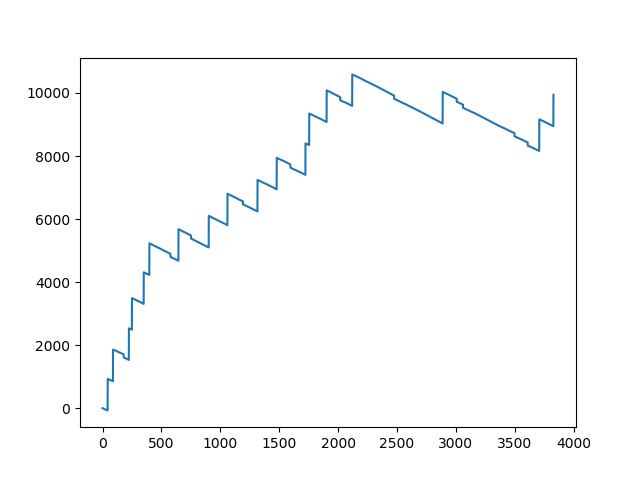

In [22]:
plt.figure()
#plt.plot(total_rewards[0])
plt.plot(total)

print(invalids)

invalids = []
invalid = 0
for step in range(10000):
    if step % 250 == 0:
        print("Still running at iteration", step)
        
    
    old_state = game.board
    action = deep_Q_learning.next_action(old_state)
    game_over, new_state, cur_player, cur_reward, _, _ = game.take_action(action)
    
    if (step + 1) % 100 == 0:
            invalids.append(invalid)
            invalid = 0
    if cur_reward < 0: # Invalid action
        deep_Q_learning.update(old_state, new_state, action, cur_reward)
        invalid += 1
        continue
        
    #print(game_over)
    #print(new_state)
    #print(cur_player)
    #print(cur_reward)
    
    if game_over:
        deep_Q_learning.update(old_state, new_state, action, cur_reward)
        game = ConnectFourSimulator()
        continue
    
    next_action = deep_Q_dummy.next_action(new_state)
    game_over, next_state, _, active_reward, passive_player, passive_reward = game.take_action(action)
    
    counting_stars = 0
    while active_reward < 0: # Invalid move (infinite loop possible?)
        next_action = deep_Q_dummy.next_action(new_state)
        game_over, next_state, _, active_reward, passive_player, passive_reward = game.take_action(next_action)
        counting_stars += 1
        if counting_stars % 1000 == 0:
            print("Counting:", counting_stars)
            print("Using action:", action)
    
    #print(game_over)
    #print(next_state)
    #print(passive_player)
    #print(passive_reward)
    
    if game_over:
        deep_Q_learning.update(old_state, new_state, action, passive_reward)
        game = ConnectFourSimulator()
    else:
        deep_Q_learning.update(old_state, new_state, action, cur_reward)
    # Missing: check for invalid move
    # Maybe add passive mode to game (for the 2nd player)
    #print("----------------------------")
        
print("Invalids:", invalids)
print("Total:", sum(invalids))

In [23]:
# Error in the end comes from the network predicting a result, which is wrong and since exploration is way down it almost
# always predicts the same action which is always wrong. Should somehow learn though (maybe replay necessary?)

# Notes
- Use memory replay --> DONE
- Maybe higher rewards needed for backpropagation of Q values?
- View reward function by playing vs the network
- View network output for certain states
<br>
<br>
- Do I even backpropagate the reward to other states than the winning one in any way?
- Maybe the problem are few games (not enough possibilities learned) -> More iterations like 10_000 games instead of iterations
- Learning rate?
<br>
<br>
- Rework memory replay batch size and epochs analog to pytorch tutorial
- Plot metrics (e.g. total reward every iteration)
- Rework code --> Readability and reusability
- Maybe rework greedy policy
- Test the pytorch agent on the dungeon example --> DONE: Works
- Try increasing the performance (For running in the cloud) -> Use timer
- Maybe no punishment for invalid moves?
- Pass possible moves to network?
- Only give out copies of the state... --> FIXED (This literally ruined every single state in the memory...)
- Copy pytorch tensors via .copy().detach() (maybe more effectively possible as well?)
<br>
<br>
- How to choose rewards and how does the agent learn the rules (punishment for invalid moves?)
- How much training is needed for a game?
- Evaluation tactics: Total reward
- Model too big?
- Don't copy model to update agent? --> Constantly creating optimizer and agent again and again
- Only learning negative values atm --> Why?

In [24]:
empty_board = np.zeros(shape=(6, 7))

In [25]:
example_board = np.array([
    [0,0,0,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0]
])
example_board2 = np.array([
    [0,0,1,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0]
])

In [26]:
print(active.next_action(example_board))
print(active.get_Q(example_board))
print(torch.max(active.get_Q(example_board), 0)[1])

tensor(17, device='cuda:0')
tensor([-34.1751, -34.0506, -34.2195, -34.0886, -34.1386, -34.0437, -34.0337,
        -34.1965, -33.9976, -34.0872, -34.1709, -34.2188, -34.1696, -34.2562,
        -34.0796, -34.2120, -34.1064, -33.8299, -34.1041, -34.3281, -34.2597,
        -34.2649, -34.2695, -34.2441, -34.2201, -34.2743, -34.2059, -34.2161,
        -34.2505, -34.2161, -34.2206, -34.0410, -34.2127, -34.2098, -34.2600,
        -34.1673, -34.1112, -34.1166, -34.1670, -34.1881, -34.2099, -34.2906],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(17, device='cuda:0')


In [27]:
print(active.next_action(example_board2))
print(active.get_Q(example_board2))
print(torch.max(active.get_Q(example_board2), 0)[1])

tensor(17, device='cuda:0')
tensor([-34.1751, -34.0506, -34.2195, -34.0886, -34.1386, -34.0437, -34.0337,
        -34.1965, -33.9976, -34.0872, -34.1709, -34.2188, -34.1696, -34.2562,
        -34.0796, -34.2120, -34.1064, -33.8299, -34.1041, -34.3281, -34.2597,
        -34.2649, -34.2695, -34.2441, -34.2201, -34.2743, -34.2059, -34.2161,
        -34.2505, -34.2161, -34.2206, -34.0410, -34.2127, -34.2098, -34.2600,
        -34.1673, -34.1112, -34.1166, -34.1670, -34.1881, -34.2099, -34.2906],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(17, device='cuda:0')


In [28]:
print(active.next_action(empty_board))
print(active.get_Q(empty_board))
print(torch.max(active.get_Q(empty_board), 0)[1])

tensor(17, device='cuda:0')
tensor([-34.1751, -34.0506, -34.2195, -34.0886, -34.1386, -34.0437, -34.0337,
        -34.1965, -33.9976, -34.0872, -34.1709, -34.2188, -34.1696, -34.2562,
        -34.0796, -34.2120, -34.1064, -33.8299, -34.1041, -34.3281, -34.2597,
        -34.2649, -34.2695, -34.2441, -34.2201, -34.2743, -34.2059, -34.2161,
        -34.2505, -34.2161, -34.2206, -34.0410, -34.2127, -34.2098, -34.2600,
        -34.1673, -34.1112, -34.1166, -34.1670, -34.1881, -34.2099, -34.2906],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(17, device='cuda:0')


game = ConnectFourSimulator()
val = input()
while val != "q":
    game_over, board, _, _, _, _ = game.take_action(int(val))
    print(game_over)
    print(board)
    print("------------------------------------")
    if not game_over:
        confirmation = "r"
        while confirmation == "r":
            pc_action = active.next_action(board)
            print(pc_action)
            confirmation = input()
            if confirmation == "c":
                game_over, board, _, _, _, _ = game.take_action(pc_action)
                print(game_over)
                print(board)
    val = input()

In [29]:
games = memory.sample(len(memory))

In [30]:
terminal_states = [ game for game in games if game[3] == 100 or game[3] == -100 ]

In [31]:
for state in terminal_states:
    print("Before:\n", state[0])
    print("After:\n", state[1])
    print("With action:", state[2])
    print("---------------------------------------")

Before:
 [[-1.  1.  1. -1. -1.  1.  1.]
 [ 1. -1. -1. -1.  1. -1. -1.]
 [ 1.  0. -1.  1.  1.  0.  1.]
 [ 0.  0.  0.  1. -1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
After:
 [[-1.  1.  1. -1. -1.  1.  1.]
 [ 1. -1. -1. -1.  1. -1. -1.]
 [ 1.  0. -1.  1.  1. -1.  1.]
 [ 0.  0.  0.  1. -1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
With action: 19
---------------------------------------
Before:
 [[-1. -1. -1.  1. -1.  1.  1.]
 [ 1. -1. -1. -1. -1. -1.  1.]
 [-1.  1. -1. -1.  1.  1. -1.]
 [-1.  1.  0.  0.  1.  0.  1.]
 [ 1.  0.  0.  0.  1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.]]
After:
 [[-1. -1. -1.  1. -1.  1.  1.]
 [ 1. -1. -1. -1. -1. -1.  1.]
 [-1.  1. -1. -1.  1.  1. -1.]
 [-1.  1.  0. -1.  1.  0.  1.]
 [ 1.  0.  0.  0.  1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.]]
With action: 24
---------------------------------------
Before:
 [[ 1. -1.  1. -1.  1.  1. -1.]
 [-1.  1.  0. -1. -1. -1.  0.]
 [ 0.  0.  0.  1.  1.  1.  0.]
 [ 0

In [32]:
for state in memory.memory[:42]:
    print("Before:\n", state[0])
    print("After:\n", state[1])
    print("With action:", state[2])
    print("Reward:", state[3])
    print("---------------------------------------")

Before:
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
After:
 [[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
With action: 3
Reward: 0
---------------------------------------
Before:
 [[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
After:
 [[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
With action: 18
Reward: -2
---------------------------------------
Before:
 [[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. 